In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [11]:
def convert_space(img, space, bgr_input=True):
    """
        Convert color space of image.
    """
    if bgr_input:
        if space == 'rgb':
            convert = cv2.COLOR_BGR2RGB
        elif space == 'hsv':
            convert = cv2.COLOR_BGR2HSV
        elif space == 'hls':
            convert = cv2.COLOR_BGR2HLS
        elif space == 'luv':
            convert = cv2.COLOR_BGR2LUV
        elif space == 'ycb':
            convert = cv2.COLOR_BGR2YCrCb
        else:
            assert False, "Use one of 'rgb','hsv','hls','luv', 'ycb'(YCrCb)"
    if not bgr_input:
        if space == 'rgb':
            return np.copy(img)
        elif space == 'hsv':
            convert = cv2.COLOR_RGB2HSV
        elif space == 'hls':
            convert = cv2.COLOR_RGB2HLS
        elif space == 'luv':
            convert = cv2.COLOR_RGB2LUV
        elif space == 'ycb':
            convert = cv2.COLOR_RGB2YCrCb
        else:
            assert False, "Use one of 'rgb','hsv','hls','luv', 'ycb'(YCrCb)"
    return cv2.cvtColor(img, convert)

In [92]:
car1 = './data/vehicles/KITTI_extracted/512.png'
car2 = './data/vehicles/KITTI_extracted/551.png'
car3 = './data/vehicles/KITTI_extracted/467.png'
car4 = './data/vehicles/KITTI_extracted/786.png'
cars = [car1, car2, car3, car4]
ncar1 = './data/non-vehicles/GTI/image239.png'
ncar2 = './data/non-vehicles/GTI/image215.png'
ncar3 = './data/non-vehicles/GTI/image169.png'
ncar4 = './data/non-vehicles/GTI/image101.png'
ncars = [ncar1, ncar2, ncar3, ncar4]

**Training Data Visualisation**

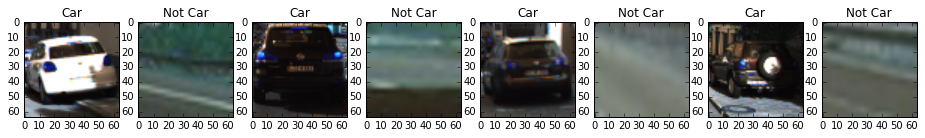

In [93]:
fig = plt.figure(figsize=(16,16))
plt.subplot(181)
plt.title("Car")
plt.imshow(cv2.imread(cars[0]))
plt.subplot(182)
plt.title("Not Car")
plt.imshow(cv2.imread(ncars[0]))
plt.subplot(183)
plt.title("Car")
plt.imshow(cv2.imread(cars[1]))
plt.subplot(184)
plt.title("Not Car")
plt.imshow(cv2.imread(ncars[1]))
plt.subplot(185)
plt.title("Car")
plt.imshow(cv2.imread(cars[2]))
plt.subplot(186)
plt.title("Not Car")
plt.imshow(cv2.imread(ncars[2]))
plt.subplot(187)
plt.title("Car")
plt.imshow(cv2.imread(cars[3]))
plt.subplot(188)
plt.title("Not Car")
plt.imshow(cv2.imread(ncars[3]))


**Visualisation Of Color Histograms**

In [90]:
def color_hist(img, nbins=32, bins_range=(0, 256), space='rgb', bgr_input=True):
    hists  = []
    img = convert_space(img, space, bgr_input=bgr_input)
    for i in range(3):
        hists.append(np.histogram(img[:,:,i],
                                  bins=32, 
                                  range=(0, 256)))
    bin_edges = hists[0][1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return hists, bin_centers, np.concatenate((hists[0], hists[1], hists[2]))

In [91]:
def showHists(image, space='rgb', bgr_input=True, a='R',b='B',c='G'):
    hists, bin_centers, fv = color_hist(image, space=space, bgr_input=bgr_input)

    fig = plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.bar(bin_centers, hists[0][0])
    plt.xlim(0, 256)
    plt.title(('%s Histogram' % a))
    plt.subplot(132)
    plt.bar(bin_centers, hists[1][0])
    plt.xlim(0, 256)
    plt.title('%s Histogram' % b)
    plt.subplot(133)
    plt.bar(bin_centers, hists[2][0])
    plt.xlim(0, 256)
    plt.title('%s Histogram' % c)
    plt.show()

Car Histogram


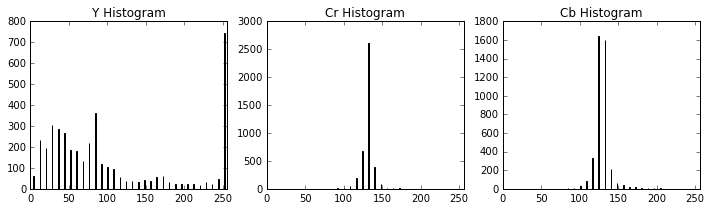

Not Car Histogram


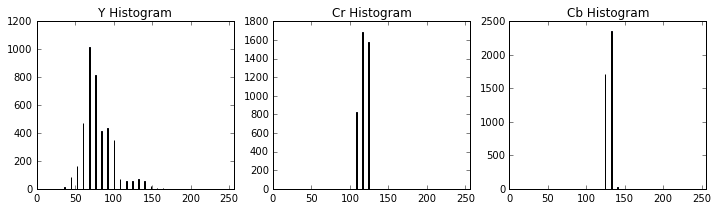

Car Histogram


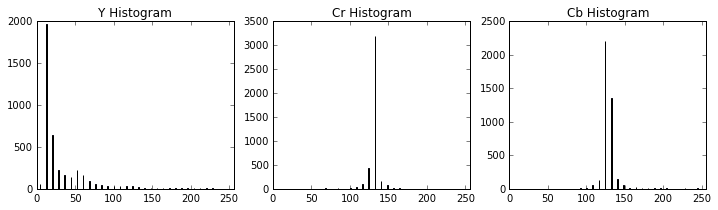

Not Car Histogram


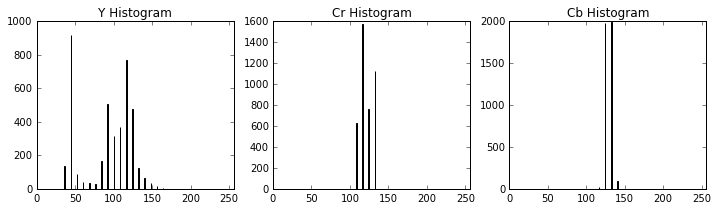

Car Histogram


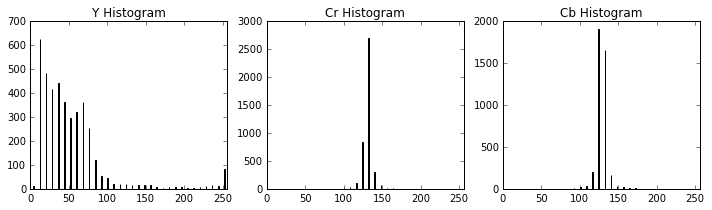

Not Car Histogram


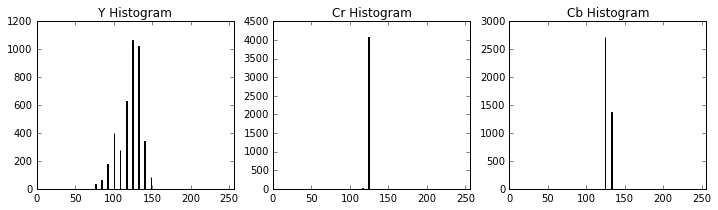

Car Histogram


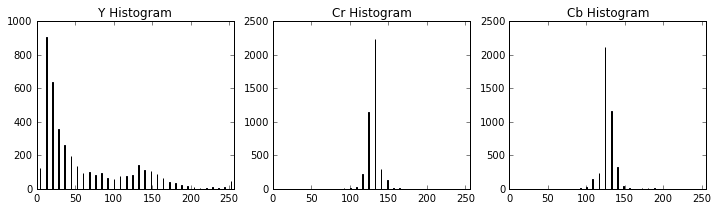

Not Car Histogram


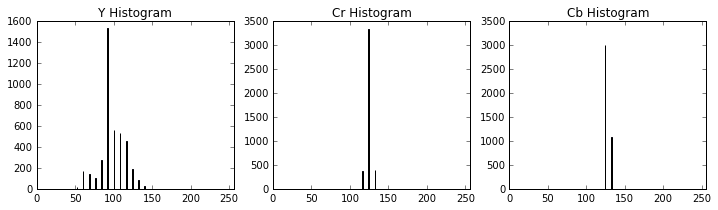

In [55]:
for car, ncar in zip(cars, ncars):
    print ("Car Histogram")
    im = cv2.imread(car)
    showHists(im, 'ycb', False, 'Y', 'Cr', 'Cb')
    print ("Not Car Histogram")
    im = cv2.imread(ncar)
    showHists(im, 'ycb', False, 'Y', 'Cr', 'Cb')

**Visualisation of HOG features**

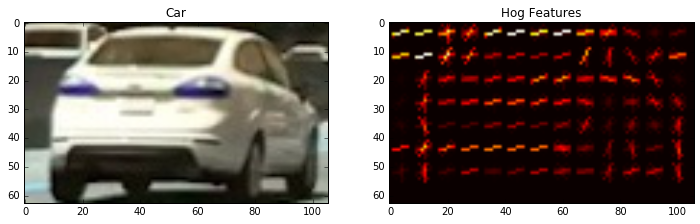

In [111]:
getHog = lambda x : hog(x, 9, (8,8), (2,2), 'L2', True)
c = cv2.imread('./cutouts/cutout1.jpg')
n = cv2.imread(ncars[0])
cf1, cim1 = getHog(c[:,:,2])
nf1, ncim1 = getHog(n[:,:,2])
f = plt.figure(figsize=(12,9))
plt.subplot(121)
plt.title("Car")
plt.imshow(c)
plt.subplot(122)
plt.title("Hog Features")
plt.imshow(cim1, cmap='hot')

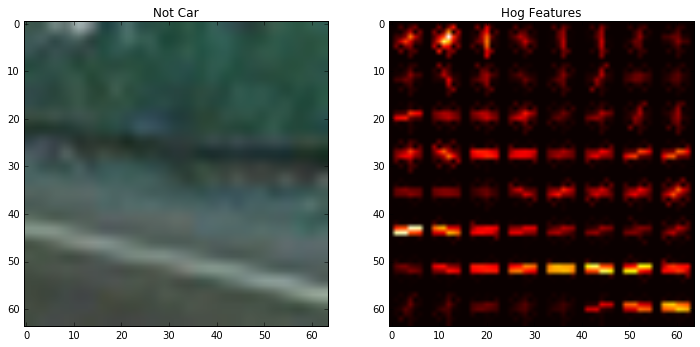

In [113]:
f = plt.figure(figsize=(12,9))
plt.subplot(121)
plt.title("Not Car")
plt.imshow(n)
plt.subplot(122)
plt.title("Hog Features")
plt.imshow(ncim1, cmap='hot')

In [114]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # Start window start stops to whole image if not specified
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # length of x and y sides of image to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    # Calculate number of windows in each direction
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):

            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            window_list.append(((startx, starty), (endx, endy)))

    return window_list

In [115]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

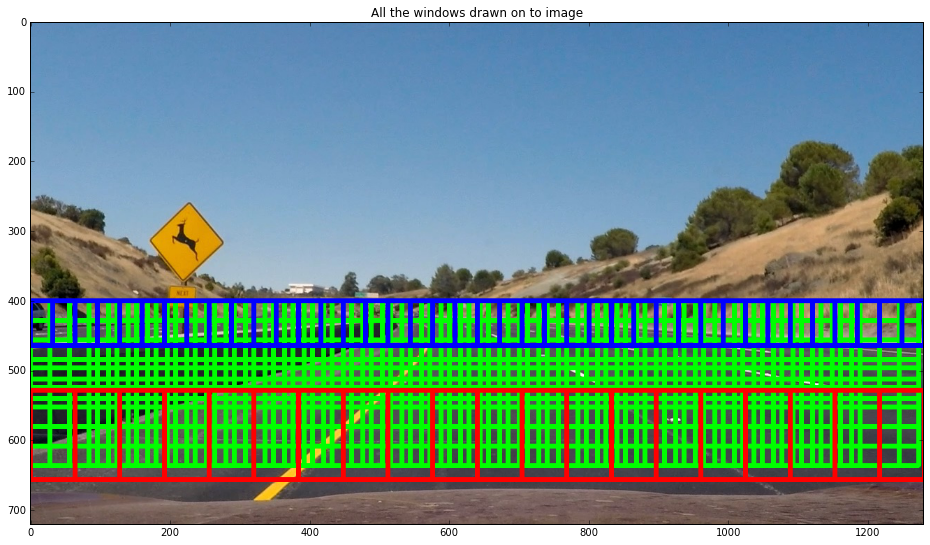

In [121]:
image = mpimg.imread('./test_images/test2.jpg')
windows1 = slide_window(image, y_start_stop=[528,656], xy_window=(128,128), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, y_start_stop=[400,656], xy_window=(96,96), xy_overlap=(0.7, 0.7))
windows3 = slide_window(image, y_start_stop=[400,464], xy_window=(64,64), xy_overlap=(0.5, 0.5))
image = draw_boxes(image, windows2, (0,255,0))
image = draw_boxes(image, windows1, (255,0,0))
image = draw_boxes(image, windows3, (0,0,2550))
f = plt.figure(figsize=(25,9))
plt.title("All the windows drawn on to image")
plt.imshow(image)